# Topic modelling with Gensim LDA

**Objective**: 

Classify topics using Latent Dirichlet Allocation (LDA) model from Gensim

**Data**: 

1) Labelled collection of student questions on 4 subjects: Physics, Chemistry, Biology, and Mathematics (https://www.kaggle.com/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data)
   
2) Labelled collection of news articles on 20 different topics (https://www.kaggle.com/crawford/20-newsgroups)
  
**References**

* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://www.kaggle.com/mrutyunjaybiswal/toughest-subject-in-exams-phy-or-math-or-chem
* https://towardsdatascience.com/topic-modeling-for-the-new-york-times-news-dataset-1f643e15caac

In [204]:
import gensim 
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string

import pyLDAvis
import pyLDAvis.gensim  
from matplotlib import pyplot as plt
from wordcloud import WordCloud

from sklearn.datasets import fetch_20newsgroups
from pprint import pprint

import pandas as pd
import numpy as np
import re

import collections
from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import spacy

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!python -m spacy download 'en_core_web_sm'

In [79]:
def remove_single_word_num(sent):
    '''
    Remove numbers and words of single length such as "x + 23 y - abc" will become "+ - abc"
    '''
    dummy_list = []
  
    for token in sent.split():
        if (not token.isdigit()) and ((token.isalpha() and len(token)>1) or (not token.isalnum())):
            dummy_list.append(token)   
  
    return ' '.join(dummy_list)

In [80]:
def insert_spaces(sentence):
    '''
    Add a space around special characters, number and digits. So "2x+y -1/3x" becomes: "2 x + y - 1 / 3 x"
    '''
    dummy_list = []
    splitted_sent = list(sentence)
    
    for i in range(len(splitted_sent)-1):
        dummy_list.append(splitted_sent[i])
        
        if splitted_sent[i].isalpha(): # if it is an alphabet
            if splitted_sent[i+1].isdigit() or (not splitted_sent[i+1].isalnum()):
                dummy_list.append(' ')
    
        elif splitted_sent[i].isdigit(): # if it is a number
            if splitted_sent[i+1].isalpha() or (not splitted_sent[i+1].isalnum()):
                dummy_list.append(' ')
        
        elif (not splitted_sent[i].isalnum()) and (splitted_sent[i] not in [' ','\\']): # if it is a special char but not ' ' already
            if splitted_sent[i+1].isalnum():
                dummy_list.append(' ')
        
    dummy_list.append(splitted_sent[-1])
  
    return ''.join(dummy_list)


In [81]:
def preprocess(a):
    # convert the characters into lower case
    a = a.lower()

    # remomve newline character
    a = re.sub("\\n", " ", a)

    # remove the pattern [ whatever here ]. Use { } or  ( ) in place of [ ] in regex
    a = re.sub(r"\[(.*?)\]",' ',a)

    # remove Questions beginners Q5. 5. question 5. 
    a = re.sub(r"^[\w]+(\s|\.)(\s|\d+(\.*(\d+|\s)))\s*", " ", a)

    # remove MathPix markdown starting from \( and ending at \) while preserving data inside \text { preserve this }
    a = re.sub(r'\s*\\+\((.*?)\\+\)', lambda x: " ".join(re.findall(r'\\[a-z]{3,}\s*{([^{}]*)}', x.group(1))), repr(a))

    # remove options from questions i.e character bounded by () given there is no spacing inside ()
    a = re.sub(r"\s*\([^)\s]*\)\s*", " ", a)

    # remove any repeating special character (more than one times) except \(){}[] and space.  So it'll remove .. ,, ___ +++ etc
    a = re.sub(r"([^a-zA-Z0-9\\ (){}\]\[])\1{1,}",' ',a)

    # remove data inside {} -> at max 2 characters {q.}, {5.}
    a = re.sub(r"{.{0,2}}", " ", a)

    # Insert spaces among spec chars, digits and nums  and then remove every single len alphabet and number
    a = remove_single_word_num(insert_spaces(a))

    # remove whatever comes after \\ double slashes except space 
    a = re.sub(r"(\\[^ ]+)",' ',a)

    #remove every special characcter
    a = re.sub(r'(\W)|([_])',' ',a)

    # remomve newline character
    a = re.sub("\\n", " ", a)

    # remove repeated space if there is any
    a = re.sub(r"\s+", " ", a)
  
    return a


In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [83]:
def remove_stopwords(text):
    res = [word for word in text.split() if word not in stop_words]
    return " ".join(res)

In [84]:
def frequent_words(data): 
    # size of vocabulary 
    counts = Counter()
    for i, news in enumerate(data):
        text = news.lower() # convert to lowercase
        counts.update(text.split()) # splitting on whitespace
    
    # select only words that appear at list 5 times
    vocabulary = len( [k for k, v in counts.items() if v > 5] )
    word_counts = sorted(counts, key=counts.get, reverse=True)
    word_counts = word_counts[1:vocabulary]
    return word_counts

In [114]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [125]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# LDA for school subject classification 
## Text analysis and NLP preprocessing

In [91]:
df = pd.read_csv("../input/iitjee-neet-aims-students-questions-data/subjects-questions.csv")
df.shape

(122519, 2)

In [92]:
topics = list( df.Subject.unique() ) 
topics

['Biology', 'Chemistry', 'Maths', 'Physics']

In [93]:
duplicates = df[df.duplicated()]
len(duplicates)

811

In [94]:
df.drop_duplicates(inplace = True)
df = df.reset_index()

In [95]:
df.isnull().sum()

index      0
eng        0
Subject    0
dtype: int64

In [96]:
df.head()

,index,eng,Subject
0,0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,1,"Among the following organic acids, the acid pr...",Chemistry
2,2,If the area of two similar triangles are equal...,Maths
3,3,"In recent year, there has been a growing\nconc...",Biology
4,4,Which of the following statement\nregarding tr...,Physics


<AxesSubplot:xlabel='Subject'>

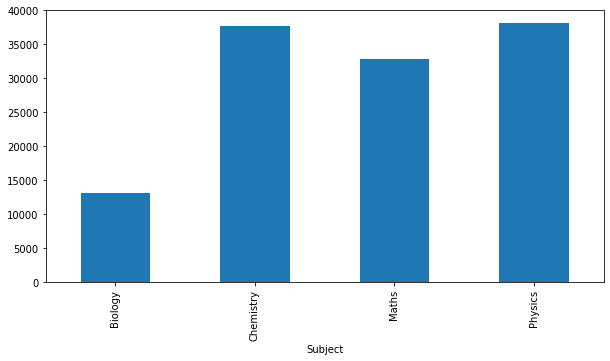

In [97]:
counts = df.groupby("Subject")["Subject"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [98]:
# count number of words per sample. strip whitespaces at the beginning/end of the sentence 
# and tokenize by whitespace
df["word_count"] = df["eng"].apply(lambda x: len(x.strip().split(" ")))

In [99]:
df["word_count"].describe()

count    121708.000000
mean         37.072493
std          24.200969
min           1.000000
25%          19.000000
50%          31.000000
75%          51.000000
max         558.000000
Name: word_count, dtype: float64

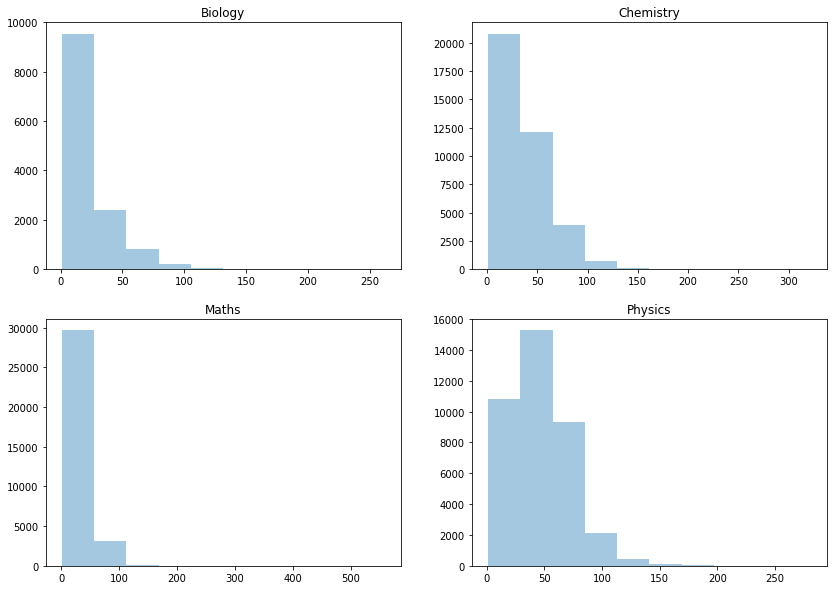

In [100]:
fig = plt.figure(figsize=(14,10))

c = 1
for t in topics: 
    sel = df[df.Subject == t].word_count
    plt.subplot(2, 2, c)
    plt.title(t)
    plt.hist(sel, bins = 10, alpha = 0.4)
    c += 1


Most commmon words before preprocessing

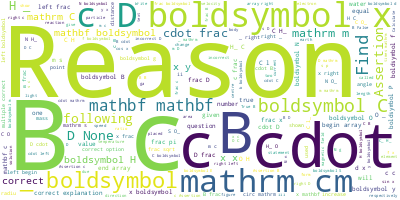

In [101]:
long_string = ','.join(list(df['eng'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [102]:
df["text_clean"] = df["eng"].apply(preprocess)
df.text_clean.head()

0     an anti forest measure is afforestation selec...
1     among the following organic acids the acid pr...
2     if the area of two similar triangles are equa...
3     in recent year there has been growing concern...
4     which of the following statement regarding tr...
Name: text_clean, dtype: object

In [106]:
# remove stopwords
stop_words = stopwords.words('english')

df["text_clean"] = df["text_clean"].apply(remove_stopwords)
df.text_clean.head()

0    anti forest measure afforestation selective gr...
1    among following organic acids acid present ran...
2    area two similar triangles equal equilateral i...
3    recent year growing concern gradually increasi...
4    following statement regarding transformer inco...
Name: text_clean, dtype: object

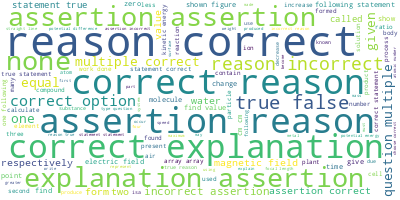

In [107]:
# wordcloud of preprocessed documents
long_string = ','.join(list(df['text_clean'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [108]:
# 20 most common words by topic
for t in topics: 
    data = df[df.Subject == t].text_clean
    words_counts = frequent_words(data)
    print(t)
    print(words_counts[:20])

Biology
['reason', 'assertion', 'following', 'water', 'one', 'cell', 'cells', 'blood', 'none', 'plants', 'acid', 'explanation', 'plant', 'incorrect', 'dna', 'two', 'true', 'ii', 'given', 'called']
Chemistry
['reason', 'following', 'assertion', 'reaction', 'solution', 'acid', 'water', 'true', 'statement', 'number', 'gas', 'explanation', 'none', 'one', 'incorrect', 'compound', 'hydrogen', 'temperature', 'energy', 'pressure']
Maths
['value', 'following', 'number', 'none', 'two', 'array', 'equal', 'correct', 'one', 'given', 'area', 'true', 'cm', 'equation', 'point', 'line', 'rs', 'triangle', 'sum', 'reason']
Physics
['reason', 'assertion', 'two', 'velocity', 'mass', 'force', 'energy', 'current', 'field', 'distance', 'magnetic', 'light', 'time', 'speed', 'point', 'electric', 'surface', 'charge', 'particle', 'find']


In [109]:
data = df.text_clean.values.tolist()
data_words = list(sent_to_words(data))
data_words[:1][0]

['anti',
 'forest',
 'measure',
 'afforestation',
 'selective',
 'grazing',
 'clearing',
 'forest',
 'selective',
 'felling']

Bigrams are two words that appear frequently together in a document (such as "stop sign", "birthday party" etc). Using the bigram model in Gensim's Phrases ensures that such word combinations are assigned to a single token. 

Arguments: 
* min_count = ignore all bigrams that appear less frequently than this threshold
* threshold = the higher, the fewer bigrams are formed

In [112]:
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [113]:
print(bigram_mod[data_words[1]])

['among', 'following', 'organic', 'acids', 'acid', 'present', 'rancid', 'butter', 'pyruvic_acid', 'lactic_acid', 'butyric', 'acid', 'acetic_acid']


In [116]:
# make bigrams for entire corpus
data_words_bigrams = make_bigrams(data_words)

In [126]:
data_lemmatized = lemmatization(data_words_bigrams)
print(data_lemmatized[:1])

[['anti', 'forest', 'measure', 'afforestation', 'selective', 'grazing', 'clearing', 'forest', 'selective', 'felling']]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) underneath implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs once and so on.

This is used as the input by the LDA model.

In [127]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# View
print(corpus[:1][0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2)]


Index 0 in the dictionary corresponds to the following word: 

In [128]:
id2word[0]

'afforestation'

Human readable corpus

In [129]:
# Human readable format of corpus (term-frequency)
corpus_clear = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
print( corpus_clear[0][:30] )

[('afforestation', 1), ('anti', 1), ('clearing', 1), ('felling', 1), ('forest', 2), ('grazing', 1), ('measure', 1), ('selective', 2)]


## LDA model for school subjects

Arguments: 
* alpha: prior for document-topic. if asymmetric, defaults to 1.0 / (topic_index + sqrt(num_topics)) 
* chunksize: number of documents to be used in each training chunk
* passes: number of passes through the corpus during training
* random_state: seed

In [131]:
topics

['Biology', 'Chemistry', 'Maths', 'Physics']

In [134]:
nr_topics = len(topics)
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha = "asymmetric",
                                       num_topics=nr_topics)

In [135]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.054*"correct" + 0.044*"reason" + 0.042*"assertion" + 0.023*"number" + '
  '0.022*"follow" + 0.021*"true" + 0.021*"find" + 0.021*"statement" + '
  '0.016*"value" + 0.015*"explanation"'),
 (1,
  '0.019*"follow" + 0.018*"use" + 0.012*"cell" + 0.012*"cm" + '
  '0.009*"resistance" + 0.008*"compound" + 0.008*"give" + 0.007*"none" + '
  '0.007*"form" + 0.006*"produce"'),
 (2,
  '0.017*"time" + 0.016*"velocity" + 0.013*"force" + 0.012*"move" + '
  '0.012*"field" + 0.011*"particle" + 0.011*"distance" + 0.011*"light" + '
  '0.011*"surface" + 0.011*"find"'),
 (3,
  '0.033*"reaction" + 0.029*"water" + 0.026*"solution" + 0.023*"increase" + '
  '0.021*"gas" + 0.021*"temperature" + 0.017*"energy" + 0.016*"pressure" + '
  '0.015*"acid" + 0.014*"decrease"')]


In [136]:
# for each document, store topic id, probability and keywords in a dictionary
data = pd.DataFrame()
for i, row_list in enumerate(doc_lda): 
    row = sorted(row_list, key = lambda x: (x[1]), reverse = True)
    topic_idx = row[0][0]
    topic_prob = row[0][1]
    wd = lda_model.show_topic(topic_idx)
    topic_keywords = ",".join([word for word, prob in wd])
    
    data.at[i, "topic_idx"] = topic_idx
    data.at[i, "topic_prob"] = topic_prob
    data.at[i, "topic_keywords"] = topic_keywords
    

In [143]:
for i in range( data.shape[0] ):
    d = data.at[i, "topic_idx"]
    if(d == 0):
        data.at[i, "topic"] = "Maths"
    elif(d == 1):
        data.at[i, "topic"] = "Biology"
    elif(d == 2):
        data.at[i, "topic"] = "Physics"
    else: 
        data.at[i, "topic"] = "Chemistry"

In [144]:
topic_df = pd.concat([df, data], axis = 1)
topic_df

,index,eng,Subject,word_count,text_clean,topic_idx,topic_prob,topic_keywords,topic
0,0,An anti-forest measure is\nA. Afforestation\nB...,Biology,12,anti forest measure afforestation selective gr...,1.0,0.931281,"follow,use,cell,cm,resistance,compound,give,no...",Biology
1,1,"Among the following organic acids, the acid pr...",Chemistry,21,among following organic acids acid present ran...,3.0,0.501591,"reaction,water,solution,increase,gas,temperatu...",Chemistry
2,2,If the area of two similar triangles are equal...,Maths,18,area two similar triangles equal equilateral i...,0.0,0.923412,"correct,reason,assertion,number,follow,true,fi...",Maths
3,3,"In recent year, there has been a growing\nconc...",Biology,31,recent year growing concern gradually increasi...,1.0,0.385768,"follow,use,cell,cm,resistance,compound,give,no...",Biology
4,4,Which of the following statement\nregarding tr...,Physics,71,following statement regarding transformer inco...,1.0,0.529067,"follow,use,cell,cm,resistance,compound,give,no...",Biology
...,...,...,...,...,...,...,...,...,...
121703,122514,Which of the following group of\ncharacters is...,Biology,45,following group characters present chordates s...,1.0,0.900416,"follow,use,cell,cm,resistance,compound,give,no...",Biology
121704,122515,Light year is the\nA. light emitted by the sun...,Physics,45,light year light emitted sun one year time tak...,2.0,0.963267,"time,velocity,force,move,field,particle,distan...",Physics
121705,122516,Member of Dipnoi are native of\nA. India.\nB. ...,Biology,16,member dipnoi native india africa australia ne...,0.0,0.685842,"correct,reason,assertion,number,follow,true,fi...",Maths
121706,122517,"In one average-life,\nA. half the active nucle...",Physics,26,one average life half active nuclei decay less...,0.0,0.502233,"correct,reason,assertion,number,follow,true,fi...",Maths


In [145]:
for i in range(topic_df.shape[0]): 
    if topic_df.Subject[i] == topic_df.topic[i]: 
        topic_df.at[i, "classification"] = 1
    else: 
        topic_df.at[i, "classification"] = 0

<AxesSubplot:xlabel='classification'>

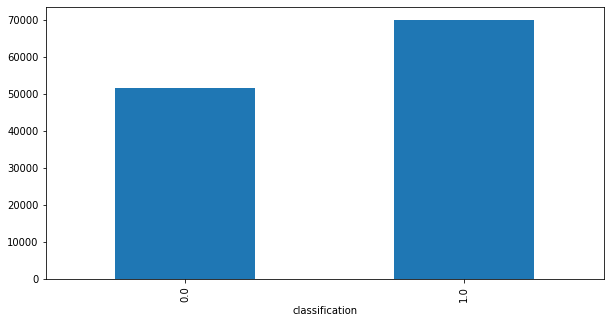

In [147]:
counts = topic_df.groupby("classification")["classification"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [148]:
# number of correctly classified texts
counts[1]/topic_df.shape[0]

0.5749909619745621

In [151]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.447006200290379

Coherence Score:  0.386740296699417


In [154]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.123648  0.265538       1        1  31.426806
2     -0.262432 -0.150399       2        1  27.496605
1      0.238949  0.112222       3        1  23.844686
3      0.147131 -0.227361       4        1  17.231903, topic_info=          Term          Freq         Total Category  logprob  loglift
153    correct  21998.000000  21998.000000  Default  30.0000  30.0000
160     reason  18097.000000  18097.000000  Default  29.0000  29.0000
150  assertion  17243.000000  17243.000000  Default  28.0000  28.0000
173   reaction   7470.000000   7470.000000  Default  27.0000  27.0000
296     number   9503.000000   9503.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
593    process   1644.452419   2877.516613   Topic4  -4.9118   1.1989
604   molecule   1337.143917   2296.337883   Topic4  -5.1186   1.2176
211    contain   1343.699737   2696.593170   Topic4  -5.1137   1.0618
12      follow   2148.400962  17293.093606   Topic4  -4.6444  -0.3272
69        give   1784.038611   9627.226004   Topic4  -4.8303   0.0727

[205 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
323       2  0.999518  acceleration
9         4  0.999628          acid
1017      2  0.186975        amount
1017      4  0.812623        amount
246       1  0.456154         angle
...     ...       ...           ...
1119      2  0.999574    wavelength
633       4  0.999734        weight
634       2  0.995797          wire
634       3  0.004106          wire
209       1  0.999762         write

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

# Classify news by topic

## Text analysis and NLP preprocessing

In [155]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'sci.med',
    'comp.graphics',
    'sci.space',
    "rec.motorcycles"
]

data_train = fetch_20newsgroups(subset='train', 
                                categories=categories, 
                                shuffle=True, random_state=42)

In [156]:
# Creating a dataframe from the loaded data
df = pd.DataFrame({'news': data_train.data, 
                   'topic': data_train.target})

print( df.shape )
df.head()

(2369, 2)


,news,topic
0,From: dmatejka@netcom.com (Daniel Matejka)\nSu...,1
1,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...,2
2,From: swoithe@crackle.uucp (Stan Woithe)\nSubj...,3
3,From: km@cs.pitt.edu (Ken Mitchum)\nSubject: R...,2
4,"From: MUNIZB%RWTMS2.decnet@rockwell.com (""RWTM...",3


In [157]:
duplicates = df[df.duplicated()]
len(duplicates)

0

In [158]:
df.isnull().sum()

news     0
topic    0
dtype: int64

<AxesSubplot:xlabel='topic'>

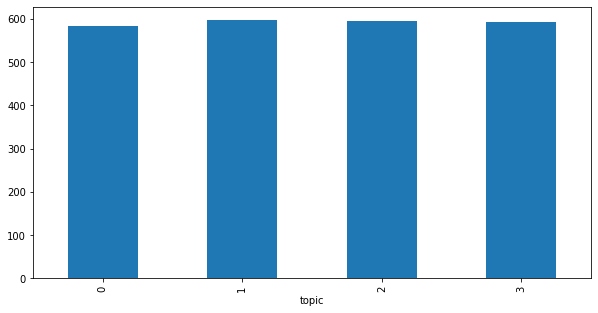

In [159]:
counts = df.groupby("topic")["topic"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [160]:
# count number of words per sample. strip whitespaces at the beginning/end of the sentence 
# and tokenize by whitespace
df["word_count"] = df["news"].apply(lambda x: len(x.strip().split(" ")))

In [161]:
df["word_count"].describe()

count    2369.000000
mean      290.205150
std       612.751098
min        11.000000
25%       107.000000
50%       175.000000
75%       278.000000
max      9555.000000
Name: word_count, dtype: float64

In [162]:
topics = list(df["topic"].unique() )
topics

[1, 2, 3, 0]

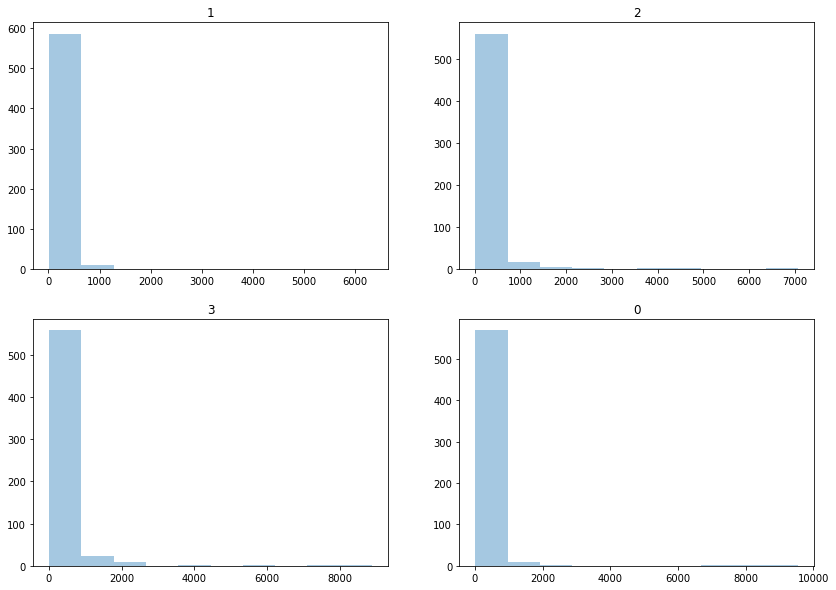

In [163]:
fig = plt.figure(figsize=(14,10))

c = 1
for t in topics: 
    sel = df[df.topic == t].word_count
    plt.subplot(2, 2, c)
    plt.title(t)
    plt.hist(sel, bins = 10, alpha = 0.4)
    c += 1


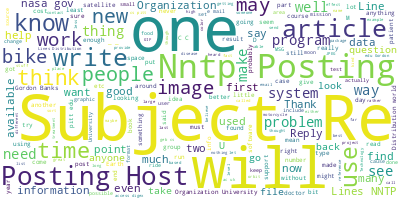

In [164]:
# Most common words before preprocessing
long_string = ','.join(list(df['news'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [165]:
df.news.head()

0    From: dmatejka@netcom.com (Daniel Matejka)\nSu...
1    From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...
2    From: swoithe@crackle.uucp (Stan Woithe)\nSubj...
3    From: km@cs.pitt.edu (Ken Mitchum)\nSubject: R...
4    From: MUNIZB%RWTMS2.decnet@rockwell.com ("RWTM...
Name: news, dtype: object

In [166]:
df["text_clean"] = df["news"].apply(cleaning_pipe)
df.text_clean.head()

0     from dmatejka netcom com daniel matejka subje...
1     from geb cs pitt edu gordon banks subject re ...
2     from swoithe crackle uucp stan woithe subject...
3     from km cs pitt edu ken mitchum subject re up...
4     from munizb rwtms decnet rockwell com subject...
Name: text_clean, dtype: object

In [167]:
# remove stopwords
stop_words = stopwords.words('english')

df["text_clean"] = df["text_clean"].apply(remove_stopwords)
df.text_clean.head()

0    dmatejka netcom com daniel matejka subject spe...
1    geb cs pitt edu gordon banks subject migraine ...
2    swoithe crackle uucp stan woithe subject mars ...
3    cs pitt edu ken mitchum subject update article...
4    munizb rwtms decnet rockwell com subject alask...
Name: text_clean, dtype: object

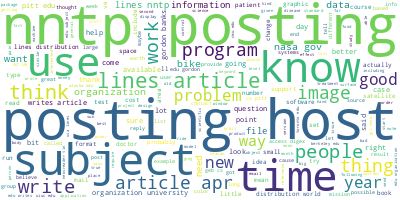

In [168]:
# wordcloud of preprocessed documents
long_string = ','.join(list(df['text_clean'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [169]:
# 20 most common words by topic
for t in topics: 
    data = df[df.topic == t].text_clean
    words_counts = frequent_words(data)
    print(t)
    print(words_counts[:20])

1
['edu', 'subject', 'organization', 'lines', 'bike', 'article', 'writes', 'dod', 'like', 'posting', 'host', 'ca', 'nntp', 'apr', 'know', 'ride', 'good', 'university', 'new', 'motorcycle']
2
['com', 'subject', 'organization', 'lines', 'article', 'writes', 'cs', 'pitt', 'people', 'msg', 'science', 'like', 'university', 'know', 'gordon', 'use', 'banks', 'medical', 'health', 'geb']
3
['edu', 'nasa', 'subject', 'organization', 'lines', 'com', 'writes', 'article', 'gov', 'like', 'posting', 'apr', 'moon', 'launch', 'orbit', 'nntp', 'host', 'earth', 'access', 'university']
0
['lines', 'subject', 'graphics', 'organization', 'image', 'com', 'university', 'posting', 'file', 'host', 'jpeg', 'nntp', 'files', 'use', 'software', 'images', 'writes', 'article', 'data', 'program']


In [170]:
data = df.text_clean.values.tolist()
data_words = list(sent_to_words(data))
print( data_words[:1][0][:30] )

['dmatejka', 'netcom', 'com', 'daniel', 'matejka', 'subject', 'speeding', 'ticket', 'chp', 'organization', 'netcom', 'online', 'communication', 'services', 'lines', 'article', 'pq', 'agate', 'berkeley', 'edu', 'downey', 'homer', 'cs', 'berkeley', 'edu', 'allen', 'downey', 'writes', 'fight', 'ticket']


In [171]:
# make bigrams
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [172]:
print(bigram_mod[data_words[1]])

['geb_cs', 'pitt', 'edu', 'gordon_banks', 'subject', 'migraine', 'reply_geb', 'cs_pitt', 'edu', 'gordon_banks', 'organization', 'univ_pittsburgh', 'science', 'lines', 'article', 'uupcb', 'factory', 'com', 'jim_zisfein', 'factory', 'com', 'jim_zisfein', 'writes', 'headaches', 'seriously', 'interfere', 'activities', 'daily', 'living', 'affect', 'population', 'sound', 'like', 'primary', 'care', 'physician', 'know', 'tend', 'agree', 'hmo', 'administrators', 'family', 'physicians', 'learn', 'basics', 'headache', 'management', 'absolutely', 'unfortunately', 'weeks', 'neurology', 'medical_school', 'month', 'residency', 'hospital', 'migraines', 'rarely', 'seen', 'supposed', 'learn', 'diligent', 'read', 'learn', 'unfortunately', 'wonder', 'tension', 'type', 'headaches', 'neurology', 'ones', 'headaches', 'spend', 'time', 'history', 'diagnose', 'primary', 'care', 'physician', 'hears', 'headache', 'loses', 'giving', 'patient', 'analgesics', 'getting', 'office', 'interesting', 'excepting', 'migrain

In [173]:
# make bigrams for entire corpus
data_words_bigrams = make_bigrams(data_words)

In [174]:
data_lemmatized = lemmatization(data_words_bigrams)
print(data_lemmatized[:1])

[['com', 'daniel_matejka', 'subject', 'speeding_ticket', 'chp', 'organization', 'communication_service', 'line', 'article', 'pq', 'homer', 'write', 'edition', 'ucb', 'library', 'let', 'know', 'go', 'write', 'fourth', 'edition', 'probably', 'high', 'ucb', 'get', 'list', 'article', 'mcimail', 'com', 'mcimail', 'com', 'write', 'ride', 'work', 'week', 'pull', 'chp', 'black_white', 'gas', 'station', 'road', 'officer', 'state', 'look', 'go', 'kinda', 'fast', 'come', 'highway', 'going', 'say', 'agree', 'disagree', 'say', 'beat', 'ticket', 'personally', 'think', 'duty', 'citizen', 'trouble', 'possible', 'maybe', 'leave', 'someday', 'soon', 'cop', 'certainly', 'legal', 'right', 'nail', 'guess', 'speed', 'brown', 'author', 'fight_ticket', 'mention', 'convict', 'speeder', 'officer', 'testimony', 'driver', 'car', 'sound', 'drive', 'excessive', 'speed', 'pay', 'state', 'insurance', 'company', 'court', 'creative', 'personally', 've', 'win', 'way', 'see', 'win', 'judge', 'listen', 'politely', 'haven_

In [190]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 2), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [191]:
# Human readable format of corpus (term-frequency)
corpus_clear = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
print( corpus_clear[0][:30] )

[('absolutely', 1), ('acceleration', 1), ('accustom', 1), ('actually', 1), ('agree', 1), ('ahem', 1), ('appear', 2), ('applause', 1), ('argument', 1), ('article', 2), ('attempt', 1), ('author', 1), ('beat', 1), ('bike', 2), ('biker', 1), ('black_white', 1), ('bring', 1), ('brown', 1), ('calculator', 1), ('car', 3), ('certainly', 1), ('chp', 2), ('citizen', 1), ('com', 3), ('come', 1), ('communication_service', 1), ('company', 1), ('confound', 1), ('convict', 1), ('convince', 1)]


## LDA model for news

In [192]:
num_topics = len(topics)
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha = "asymmetric",
                                       num_topics=num_topics)

In [193]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"com" + 0.011*"line" + 0.009*"subject" + 0.008*"article" + '
  '0.008*"write" + 0.007*"organization" + 0.005*"know" + 0.004*"patient" + '
  '0.004*"people" + 0.004*"cause"'),
 (1,
  '0.016*"space" + 0.005*"launch" + 0.005*"orbit" + 0.005*"science" + '
  '0.005*"subject" + 0.005*"line" + 0.005*"earth" + 0.004*"year" + '
  '0.004*"mission" + 0.004*"program"'),
 (2,
  '0.014*"image" + 0.013*"line" + 0.011*"file" + 0.008*"graphic" + '
  '0.007*"subject" + 0.006*"program" + 0.006*"write" + 0.006*"use" + '
  '0.006*"format" + 0.005*"color"'),
 (3,
  '0.020*"com" + 0.013*"write" + 0.013*"line" + 0.011*"article" + '
  '0.011*"subject" + 0.009*"bike" + 0.009*"organization" + 0.006*"nntp_poste" '
  '+ 0.006*"host" + 0.006*"think"')]


In [199]:
# for each document, store topic id, probability and keywords in a dictionary
data = pd.DataFrame()
for i, row_list in enumerate(doc_lda): 
    row = sorted(row_list, key = lambda x: (x[1]), reverse = True)
    topic_idx = row[0][0]
    topic_prob = row[0][1]
    wd = lda_model.show_topic(topic_idx)
    topic_keywords = ",".join([word for word, prob in wd])
    
    data.at[i, "topic_idx"] = int( topic_idx )
    data.at[i, "topic_prob"] = topic_prob
    data.at[i, "topic_keywords"] = topic_keywords
    

In [200]:
topic_df = pd.concat([df, data], axis = 1)
topic_df

,news,topic,word_count,text_clean,topic_idx,topic_prob,topic_keywords
0,From: dmatejka@netcom.com (Daniel Matejka)\nSu...,1,516,dmatejka netcom com daniel matejka subject spe...,3.0,0.995012,"com,write,line,article,subject,bike,organizati..."
1,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...,2,224,geb cs pitt edu gordon banks subject migraine ...,0.0,0.992749,"com,line,subject,article,write,organization,kn..."
2,From: swoithe@crackle.uucp (Stan Woithe)\nSubj...,3,215,swoithe crackle uucp stan woithe subject mars ...,2.0,0.466995,"image,line,file,graphic,subject,program,write,..."
3,From: km@cs.pitt.edu (Ken Mitchum)\nSubject: R...,2,138,cs pitt edu ken mitchum subject update article...,0.0,0.874767,"com,line,subject,article,write,organization,kn..."
4,"From: MUNIZB%RWTMS2.decnet@rockwell.com (""RWTM...",3,150,munizb rwtms decnet rockwell com subject alask...,1.0,0.769281,"space,launch,orbit,science,subject,line,earth,..."
...,...,...,...,...,...,...,...
2364,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...,2,111,geb cs pitt edu gordon banks subject request i...,0.0,0.987053,"com,line,subject,article,write,organization,kn..."
2365,From: gmark@cbnewse.cb.att.com (gilbert.m.stew...,2,33,gmark cbnewse cb att com subject oxaprozin org...,0.0,0.972500,"com,line,subject,article,write,organization,kn..."
2366,From: ron.roth@rose.com (ron roth)\nSubject: S...,2,316,ron roth rose com ron roth subject selective p...,0.0,0.992820,"com,line,subject,article,write,organization,kn..."
2367,From: kmembry@viamar.UUCP (Kirk Membry)\nSubje...,0,128,kmembry viamar uucp kirk membry subject rumour...,3.0,0.622622,"com,write,line,article,subject,bike,organizati..."


In [201]:
for i in range(topic_df.shape[0]): 
    if topic_df.topic[i] == topic_df.topic_idx[i]: 
        topic_df.at[i, "classification"] = 1
    else: 
        topic_df.at[i, "classification"] = 0

<AxesSubplot:xlabel='classification'>

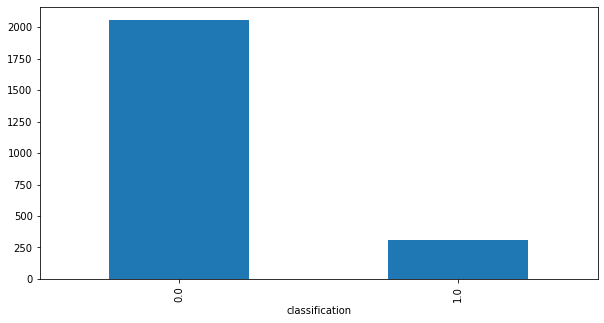

In [202]:
counts = topic_df.groupby("classification")["classification"].agg("count")

fig, ax = plt.subplots(figsize=(10,5))
counts.plot.bar()

In [203]:
# number of correctly classified texts
counts[1]/topic_df.shape[0]

0.13170113972140143

In [207]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.210644222730648

Coherence Score:  0.4872881479297726


In [208]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.112747  0.032046       1        1  29.467799
0     -0.107146  0.004875       2        1  24.130325
1      0.078583 -0.149103       3        1  23.538118
2      0.141309  0.112182       4        1  22.863758, topic_info=             Term         Freq        Total Category  logprob  loglift
315         space  1004.000000  1004.000000  Default  30.0000  30.0000
523         image   794.000000   794.000000  Default  29.0000  29.0000
337          file   601.000000   601.000000  Default  28.0000  28.0000
13           bike   651.000000   651.000000  Default  27.0000  27.0000
339       graphic   444.000000   444.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
301          help   192.698840   476.054431   Topic4  -5.6310   0.5712
456         thank   172.233015   351.571624   Topic4  -5.7433   0.7621
23            com   276.480336  2397.744005   Topic4  -5.2700  -0.6845
87   organization   244.242581  1443.933575   Topic4  -5.3940  -0.3013
213   information   172.400861   471.612349   Topic4  -5.7423   0.4693

[311 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6883      2  0.988942        adult
1439      1  0.982365  advertising
2704      1  0.975697          ama
2704      2  0.023797          ama
1592      4  0.989875    animation
...     ...       ...          ...
323       1  0.283550         year
323       2  0.296662         year
323       3  0.388447         year
323       4  0.032780         year
2231      2  0.982899        yeast

[548 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])